# Twitter Sentiment Capstone

**Author: Mohamed Emran**

**Date: 6/26/2023**

# Notebook 2 - Preprocessing and Base Model

## Table of Contents

1. [Introduction](#Introduction)<br>
2. [Taking a Sample data](#2.-Taking-a-Sample-data)
3. [Data Preprocessing](#3.-Data-Preprocessing)
    - Creating Text Vector - Count Vectorizer
    - Logistic Regression
    - Model Evaluation
    - Creating Text Vector - TF-IDF Vectorization
    - Logistic Regression
    - Model Evaluation
4. [Saving the file](#4.-Saving-file)
5. [Summary](#5.-Summary)


## 1. Introduction

In the previous notebook, Part 1 Data Cleaning and EDA, we performed data cleaning and Exploratory data analysis (EDA) on our dataset.

In this notebook, we will cover feature enigneering, which involves `text vectorization`. In addition, trying different scaling option such as StandardScaler, MinMax and RobustScaler and finally will try out a base model which is a logistic regression.

**Text vectoriziation**, is the process of transforming text into numerical and vectorizing into a set of features, will be using common techniques which are Bag Of Words (BoW Words), Term Frequency-Inverse Document Frequency ( TF-IDF)

In [222]:
# import packages

import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
import re

# Importing library to show a progress bar
from tqdm.notebook import tnrange, tqdm_notebook

# hide warnings
import warnings
warnings.filterwarnings("ignore")

# from sklearn.pipeline import Pipeline
# import preprocessing library
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# from sklearn.decomposition import PCA

In [223]:
# Import dataset
df = pd.read_csv('cleaned_twitter_data.csv')

Check shape of the data

In [224]:
print(f'The dataframe consists of {df.shape[0]} million rows, and {df.shape[1]} columns')

The dataframe consists of 1581247 million rows, and 13 columns


In [225]:
df.sample(2)

,Sentiment,User,Tweet,Tagging,Hashtags,Emojis,Month,Day,Year,Hour,Minutes,Seconds,DayOfWeek
419852,0,prettyboib07,no homo but wut type of gurl would u be involv...,livingd0ll,NaN,None,6,7,2009,0,29,14,Sunday
1344051,1,waitfortherain,after seeing the promo for the new sonny with ...,NaN,NaN,None,6,5,2009,14,45,9,Friday


Check if there are any null values

In [226]:
df.isna().sum()

Sentiment          0
User               0
Tweet              0
Tagging       854040
Hashtags     1546447
Emojis             0
Month              0
Day                0
Year               0
Hour               0
Minutes            0
Seconds            0
DayOfWeek          0
dtype: int64

We are getting null values from `Tagging` and `Hashtags` columns we can replace it with a `None`for now

In [227]:
df['Tagging'] = df['Tagging'].fillna('None')
df['Hashtags'] = df['Hashtags'].fillna('None')

In [228]:
df.isna().sum()

Sentiment    0
User         0
Tweet        0
Tagging      0
Hashtags     0
Emojis       0
Month        0
Day          0
Year         0
Hour         0
Minutes      0
Seconds      0
DayOfWeek    0
dtype: int64

Our Data is clean. We can move ahead

### 2. Taking a Sample data

In [229]:
# copying 5% of data
df_chunk = df.sample(frac=0.05).copy()

In [230]:
print(f'The dataframe consists of {df.shape[0]} million rows, and {df.shape[1]} columns')

The dataframe consists of 1581247 million rows, and 13 columns


In [231]:
df_chunk['Sentiment'].value_counts()

0    39578
1    39484
Name: Sentiment, dtype: int64

In [232]:
df_chunk['Sentiment'].value_counts(normalize=True)

0    0.500594
1    0.499406
Name: Sentiment, dtype: float64

After taking a sample data, our sentiment data are still normally distributed

In [233]:
# Reseting the index after taking the sample data
df_chunk = df_chunk.reset_index(drop=True)

In [234]:
df_chunk.head(2)

,Sentiment,User,Tweet,Tagging,Hashtags,Emojis,Month,Day,Year,Hour,Minutes,Seconds,DayOfWeek
0,0,liam_says,any way to get soundcheck entrance to nj show ...,yelyahwilliams,None,None,6,17,2009,17,5,6,Wednesday
1,0,xvampyraxhavocx,bummed i wont get to talk to my girlfriend unt...,None,None,None,5,9,2009,19,40,2,Saturday


---
### 3. Data Preprocessing

In [235]:
# Importing libraries 

# splitting our data into train and test sets
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# import countvectorizer and TF-IDF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [236]:
df_chunk.head(2)

,Sentiment,User,Tweet,Tagging,Hashtags,Emojis,Month,Day,Year,Hour,Minutes,Seconds,DayOfWeek
0,0,liam_says,any way to get soundcheck entrance to nj show ...,yelyahwilliams,None,None,6,17,2009,17,5,6,Wednesday
1,0,xvampyraxhavocx,bummed i wont get to talk to my girlfriend unt...,None,None,None,5,9,2009,19,40,2,Saturday


Let's split our data into train and test sets

    - Independent varaiable: Tweet
    - Dependent variable: Sentiment

In [237]:
X = pd.DataFrame(df_chunk['Tweet']) # indep
y = df_chunk["Sentiment"] # dep

Check the shape of the Data after split

In [238]:
X.shape

(79062, 1)

In [239]:
y.shape

(79062,)

In [240]:
# Test set 20 percent
X_rem, X_test, y_rem, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state=1)

In [241]:
# Splitting the remainder in two chunks
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size = 0.3, stratify=y_rem, random_state=1)

In [242]:
print(f'Shape of X-test set: {X_test.shape}')
print(f'Shape of X remainder set: {X_rem.shape}')

print(f'Shape of validation set: {X_val.shape}')
print(f'Shape of train set: {X_train.shape}')

Shape of X-test set: (15813, 1)
Shape of X remainder set: (63249, 1)
Shape of validation set: (18975, 1)
Shape of train set: (44274, 1)


Our final proportions end up being
* Test Set: *0.2*
* Validation Set:  0.8 * 0.3 = *0.24*
* Training Set: 0.8 * 0.7 = *0.56*

### Creating Text Vector - Count Vectorizer

We have to keep in mind vectorizing the text data could be alot of features been created, which may consume computation power.

Let's go ahead and check how many features will it create

In [243]:
# Initialize countvectorizer
bagofwords_vector = CountVectorizer(stop_words="english")

bagofwords_vector.fit(X_train['Tweet'])

X_train_transform = bagofwords_vector.transform(X_train['Tweet'])
X_val_transform = bagofwords_vector.transform(X_val['Tweet'])
X_test_transform = bagofwords_vector.transform(X_test['Tweet'])

In [244]:
X_train_transform

<44274x34526 sparse matrix of type '<class 'numpy.int64'>'
	with 276488 stored elements in Compressed Sparse Row format>

In [245]:
X_val_transform

<18975x34526 sparse matrix of type '<class 'numpy.int64'>'
	with 108407 stored elements in Compressed Sparse Row format>

In [246]:
X_test_transform

<15813x34526 sparse matrix of type '<class 'numpy.int64'>'
	with 90719 stored elements in Compressed Sparse Row format>

A total of 34,971 unique words which is a lot of features had been created. This will slow down in running a model in our local machine.

I shall set min_df for CountVectorizer, to help filter out the less relevant, and max features hyperparameter will be set to 2000, which will only allow 2000 most used part of the vectorized result. 

Moreover, will also include lemmitizer, where each word is mapped to a fixed meaningful form, and n-grams will help us preserve the order of words that is mostly lost in the bag-of-words model.

In [247]:
# importing nltk package
import nltk
from nltk.stem import WordNetLemmatizer

In [248]:
# initialize WordNetLemmatizer
lemmatizer_bow = WordNetLemmatizer()

# Initialize countvectorizer
bagofwords_vector = CountVectorizer(stop_words="english",
                                    tokenizer=lambda x: [lemmatizer_bow.lemmatize(i) for i in x.split()], 
                                    min_df=3, max_features=2000, ngram_range=(1, 3))
# Fit
bagofwords_vector.fit(X_train['Tweet'])

# transform
X_train_transform = bagofwords_vector.transform(X_train['Tweet'])
X_val_transform = bagofwords_vector.transform(X_val['Tweet'])
X_test_transform = bagofwords_vector.transform(X_test['Tweet'])

In [249]:
# check the shape after vectorizing
X_train_transform

<44274x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 226179 stored elements in Compressed Sparse Row format>

In [250]:
X_val_transform

<18975x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 95401 stored elements in Compressed Sparse Row format>

In [251]:
# check the shape after vectorizing
X_test_transform

<15813x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 79768 stored elements in Compressed Sparse Row format>

After setting the hyperparameter the total unique words has gone down from 34,971 to 2000. 

We still consider 2000 unique words are alot but can work fine with our baseline model

In [252]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
X_train_df_vect = pd.DataFrame(columns=bagofwords_vector.get_feature_names_out(), data=X_train_transform.toarray())
X_train_df_vect

,able,absolutely,abt,accident,account,ache,act,action,actually,ad,...,youre,youre welcome,youtube,youve,youve got,yr,yum,yummy,yup,z
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44269,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44270,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44271,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44272,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [253]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
X_val_df_vect = pd.DataFrame(columns=bagofwords_vector.get_feature_names_out(), data=X_val_transform.toarray())
X_val_df_vect

,able,absolutely,abt,accident,account,ache,act,action,actually,ad,...,youre,youre welcome,youtube,youve,youve got,yr,yum,yummy,yup,z
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18970,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18971,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18972,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18973,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [254]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
X_test_df_vect = pd.DataFrame(columns=bagofwords_vector.get_feature_names_out(), data=X_test_transform.toarray())
X_test_df_vect

,able,absolutely,abt,accident,account,ache,act,action,actually,ad,...,youre,youre welcome,youtube,youve,youve got,yr,yum,yummy,yup,z
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15808,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15809,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15810,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15811,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [255]:
# check to see if the shape are equal 
X_train_df_vect.shape[0] == X_train.shape[0]

True

In [256]:
words = bagofwords_vector.get_feature_names_out()
some_indices = range(1, 2000, round(2000/10))
samples = [words[i] for i in some_indices]
print(samples)

['absolutely', 'burnt', 'different', 'follower day using', 'hope youre', 'leaving', 'nervous', 'really need', 'start day', 'u']


We can observe that we see some n-grams of words

In [257]:
# creating a data frame to plot a bar graph
word_counts = pd.DataFrame(
    {"counts": X_train_transform.toarray().sum(axis=0)},
    index=bagofwords_vector.get_feature_names_out()
).sort_values("counts", ascending=False)

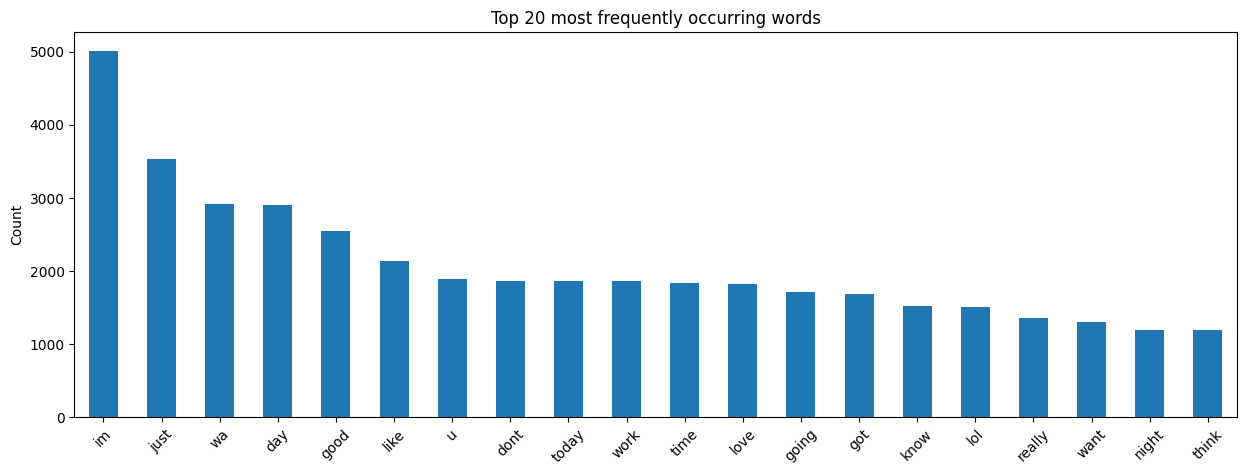

In [258]:
word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

We can observe the top 20 most frequently occuring words, and `im` has the highest occuring words.

Let's test our model with logistic regression

### Logistic Regression using Count Vectorizer

In [259]:
from sklearn.linear_model import LogisticRegression

In [260]:
# Initializing Scale
scaler = RobustScaler()

# Fitting scale
scaler.fit(X_train_df_vect)

# Transform scale
X_train_scaled = scaler.transform(X_train_df_vect)
X_val_scaled = scaler.transform(X_val_df_vect)
X_test_scaled = scaler.transform(X_test_df_vect)

In [261]:
# instantiate model
logreg_model = LogisticRegression(max_iter=10000, random_state=1)

# fit the model
logreg_model.fit(X_train_scaled, y_train)

# Training and test score
print(f"Train score: {logreg_model.score(X_train_scaled, y_train)}")
print(f"Validate score: {logreg_model.score(X_val_scaled, y_val)}")
print(f"Test score: {logreg_model.score(X_test_scaled, y_test)}")

Train score: 0.7709490897592266
Validate score: 0.741133069828722
Test score: 0.7414785303231518


In [262]:
# creating a dataframe to plot a bar graph
word_coefficients = pd.DataFrame(
    {"coefficients": logreg_model.coef_[0]},
    index=bagofwords_vector.get_feature_names_out()
).sort_values("coefficients", ascending=False)

<Figure size 640x480 with 0 Axes>

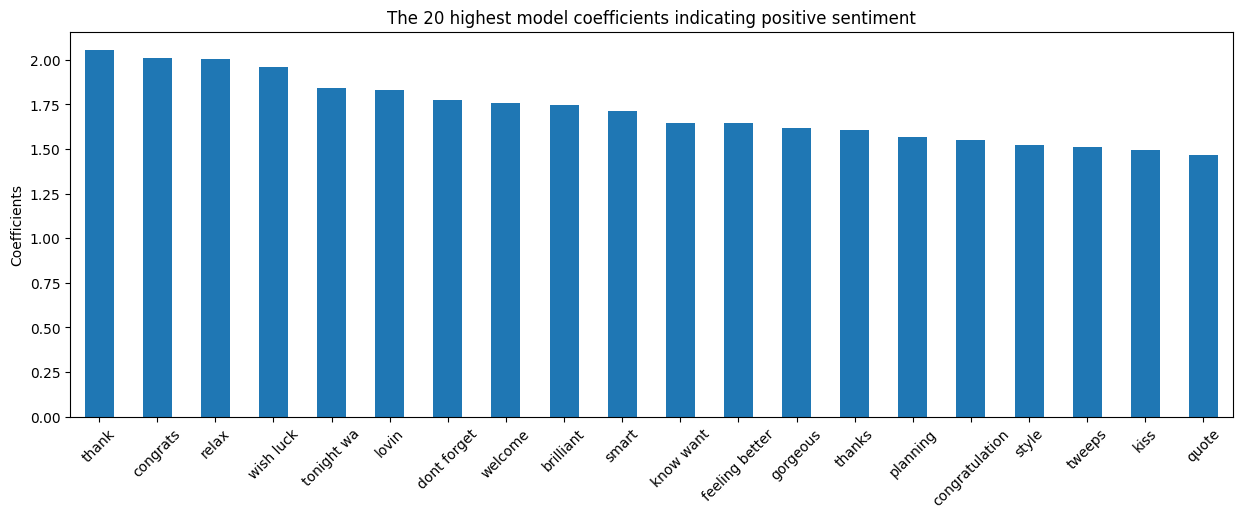

In [263]:
# let's plot a bar graph and show 20 highest positive sentiment
plt.figure()
word_coefficients.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 highest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

We can observe a good amount of positive words in the graph above

<Figure size 640x480 with 0 Axes>

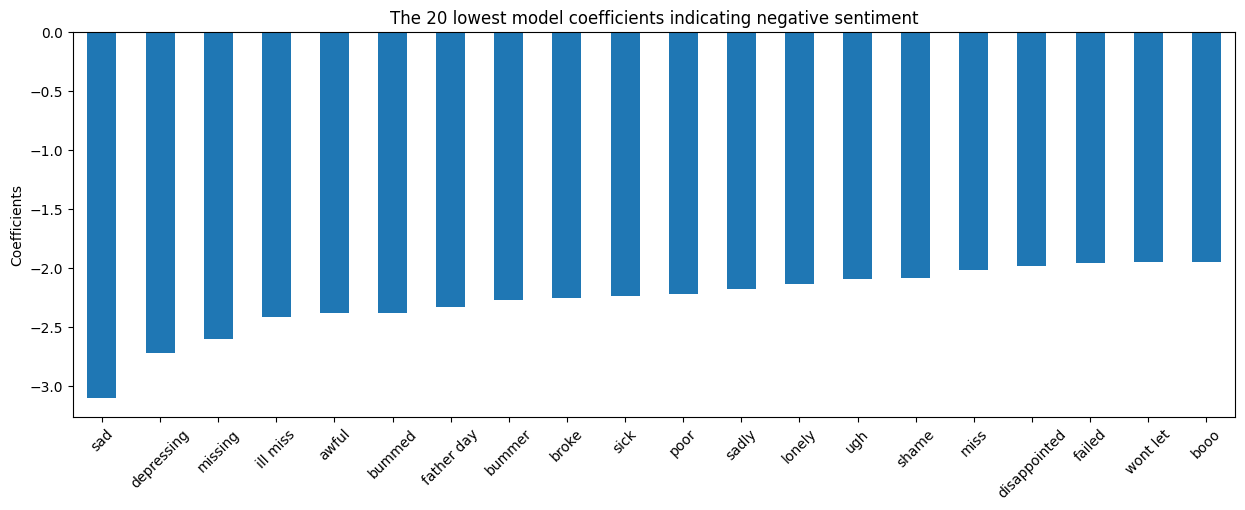

In [264]:
# let's plot a bar graph and show 20 lowest negative sentiment
plt.figure()
word_coefficients.sort_values("coefficients", ascending=True).head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 lowest model coefficients indicating negative sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

Intresting to see some negative sentiment words

### Model Evaluation

#### Confusion Matrix for the LogisticRegression On CountVectorizer

In [265]:
#Import the confusion matrix libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Importing the classification report library
from sklearn.metrics import classification_report

In [266]:
# Importing precision and recall score libraries
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [267]:
# Get class predictions
y_pred = logreg_model.predict(X_test_scaled)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Negative", "Predicted Positive"],
    index=["True Negative", "True Positive"]
)

display(cf_df)

,Predicted Negative,Predicted Positive
True Negative,5604,2312
True Positive,1776,6121


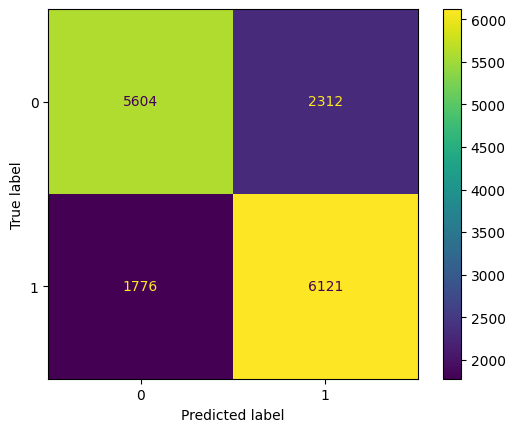

In [268]:
# the function expects the estimator, inputs and target as parameters
ConfusionMatrixDisplay.from_estimator(logreg_model, X_test_scaled, y_test)

Let's interpret these numbers of the confusion matrix:

* **True Negative**: `5646` are correctly predicted as negative Tweet
* **False Positive**: `2293` that where incorrectly classified as positive Tweet

* **False Negative**: `1820` incorrectly predicted as a negative Tweet 
* **True Positive**: `6054` correctly predicted as postive Tweet

The total of True values (TP + TN) are much higher than the total of False values (FP + FN) indicating a higher accuracy

But with regards to sentiment analysis we want a higher recall rate (how well the model identifies the positive or negative Tweet correctly vs the total positive or negative in the dataset)

In [269]:
#Now the classification report can be generated
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.76      0.71      0.73      7916
           1       0.73      0.78      0.75      7897

    accuracy                           0.74     15813
   macro avg       0.74      0.74      0.74     15813
weighted avg       0.74      0.74      0.74     15813



As we predicted we have a good accuracy score of 74%, and enough a decent recall rate 71% as negative Tweet and 77% for the positive Tweet. 

We can try to improve the recal rate by adjusting the threshold using y_proba.

Let's see how much the recall has improved after we adjust the y_proba rate to 0.2.

In [270]:
# Make probabilistic predictions (scores)
y_proba = logreg_model.predict_proba(X_test_scaled)[:,1]

In [271]:
# First calculate precision and recall using the default (0.5) cut-off
y_threshold = np.where(y_proba > 0.5, 1, 0)
print("Threshold of 0.5:")
print(f"Precision score: {precision_score(y_test, y_threshold)}")
print(f"Recall score: {recall_score(y_test, y_threshold)}")
print("")

# Calculate the same using a much lower cut-off (0.1)
y_threshold = np.where(y_proba > 0.2, 1, 0)
print("Threshold of 0.2:")
print(f"Precision score: {precision_score(y_test, y_threshold)}")
print(f"Recall score: {recall_score(y_test, y_threshold)}")

Threshold of 0.5:
Precision score: 0.7258389659670342
Recall score: 0.7751044700519184

Threshold of 0.2:
Precision score: 0.6014137681741505
Recall score: 0.9480815499556794


So by reducing the y_proba from 0.5 to 0.2 we see an increase significantly in a Recall

### Creating Text Vector - TF-IDF Vectorization

Since we already tested out the `CountVectorizer` we can try the same hyperparamter and compare it with the baseline model

In [272]:
# initialize
lemmatizer_tfidf = WordNetLemmatizer()

# initialiize TF-IDF
tfidf_vector = TfidfVectorizer(stop_words="english", 
                               tokenizer=lambda x: [lemmatizer_tfidf.lemmatize(i) for i in x.split()], 
                               min_df=3, max_features=2000, ngram_range=(1, 3))
# 2. Fit
tfidf_vector.fit(X_train['Tweet'])

# 3. Transform - tokenize (split to words) & count for each sentence how many times each occurs
X_train_tfidf_transform = tfidf_vector.transform(X_train['Tweet'])
X_val_tfidf_transform = tfidf_vector.transform(X_val['Tweet'])
X_test_tfidf_transform = tfidf_vector.transform(X_test['Tweet'])

In [273]:
# check the shape after vectorizing
X_train_tfidf_transform

<44274x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 226179 stored elements in Compressed Sparse Row format>

In [274]:
X_val_tfidf_transform

<18975x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 95401 stored elements in Compressed Sparse Row format>

In [275]:
# check the shape after vectorizing
X_test_tfidf_transform

<15813x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 79768 stored elements in Compressed Sparse Row format>

In [276]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
X_train_df_tfidf_vect = pd.DataFrame(columns=tfidf_vector.get_feature_names_out(), data=X_train_tfidf_transform.toarray())
X_train_df_tfidf_vect

,able,absolutely,abt,accident,account,ache,act,action,actually,ad,...,youre,youre welcome,youtube,youve,youve got,yr,yum,yummy,yup,z
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.235473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [277]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
X_val_df_tfidf_vect = pd.DataFrame(columns=tfidf_vector.get_feature_names_out(), data=X_val_tfidf_transform.toarray())
X_val_df_tfidf_vect

,able,absolutely,abt,accident,account,ache,act,action,actually,ad,...,youre,youre welcome,youtube,youve,youve got,yr,yum,yummy,yup,z
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [278]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
X_test_df_tfidf_vect = pd.DataFrame(columns=tfidf_vector.get_feature_names_out(), data=X_test_tfidf_transform.toarray())
X_test_df_tfidf_vect

,able,absolutely,abt,accident,account,ache,act,action,actually,ad,...,youre,youre welcome,youtube,youve,youve got,yr,yum,yummy,yup,z
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [279]:
#sanity check - to make sure the shape are equal
X_train_df_tfidf_vect.shape[0] == X_train.shape[0]

True

In [280]:
#Checking the shape of the summary dataframe
print(f'There are {X_train_df_tfidf_vect.shape[0]} rows, and {X_train_df_tfidf_vect.shape[1]}\
columns in the X_train summary dataframe')

There are 44274 rows, and 2000columns in the X_train summary dataframe


---
### Logistic Regression using TF-IDF Vectorizer

In [281]:
# Initializing Scale
scaler = RobustScaler()

# Fitting scale
scaler.fit(X_train_df_tfidf_vect)

# Transform scale
X_train_scaled_tfidf = scaler.transform(X_train_df_tfidf_vect)
X_val_scaled_tfidf = scaler.transform(X_val_df_tfidf_vect)
X_test_scaled_tfidf = scaler.transform(X_test_df_tfidf_vect)

In [282]:
# instantiate model
logreg_model_tfidf = LogisticRegression(max_iter=10000, random_state=1)

# fit the model
logreg_model_tfidf.fit(X_train_scaled_tfidf, y_train)

# Training and test score
print(f"Train score: {logreg_model_tfidf.score(X_train_scaled_tfidf, y_train)}")
print(f"Validate score: {logreg_model_tfidf.score(X_val_scaled_tfidf, y_val)}")
print(f"Test score: {logreg_model_tfidf.score(X_test_scaled_tfidf, y_test)}")

Train score: 0.7714459953923296
Validate score: 0.7432411067193676
Test score: 0.7407829001454499


|     Logistic Regression    | Train Score | Validation score | Test score |
|:--------------------------:|-------------|:----------------:|:----------:|
| Bag-of-Words Vectorization |    77.28%   |      74.20%      |   73.98%   |
| TF-IDF Vectorization       |    77.10%   |      74.59%      |   74.17%   |

We can see a small comparison while using a different `Vectorization`, due to a samll percentage difference in accuracy score, we can consider TF-IDF as the vector to use for vectorizing our data and giving weight to important and rare words.

In [283]:
# creating a dataframe to plot a bar graph
word_coefficients = pd.DataFrame(
    {"coefficients": logreg_model_tfidf.coef_[0]},
    index=tfidf_vector.get_feature_names_out()
).sort_values("coefficients", ascending=False)

<Figure size 640x480 with 0 Axes>

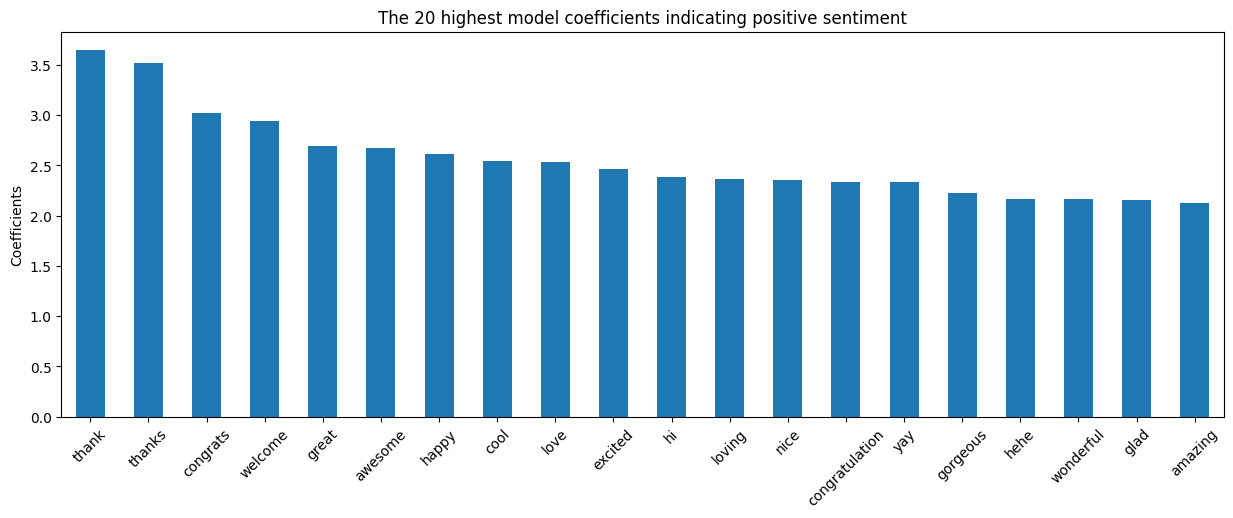

In [284]:
# let's plot a bar graph and show 20 highest positive sentiment
plt.figure()
word_coefficients.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 highest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

<Figure size 640x480 with 0 Axes>

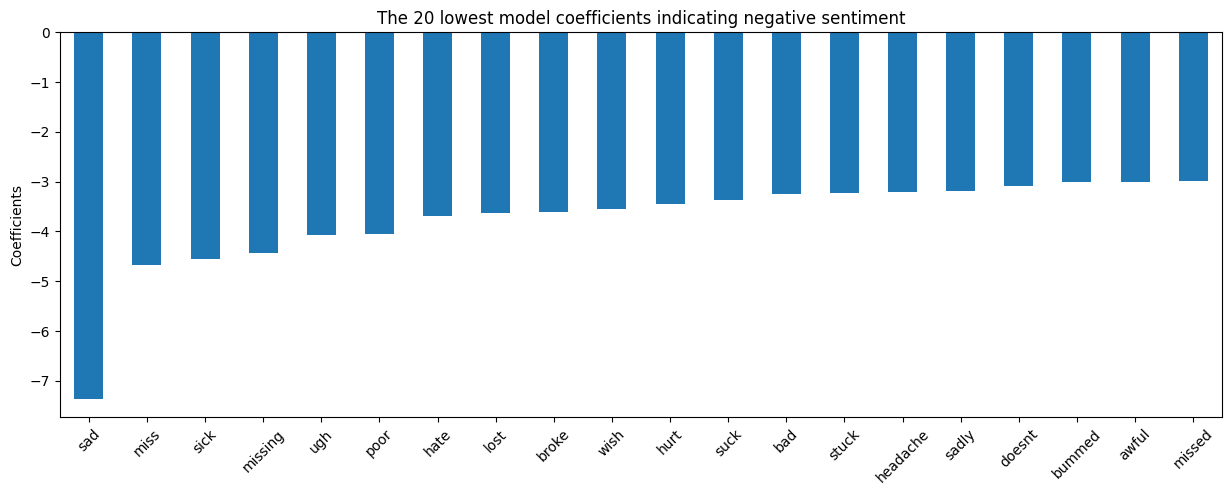

In [285]:
# let's plot a bar graph and show lowest 20 negative sentiment.
plt.figure()
word_coefficients.sort_values("coefficients", ascending=True).head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 lowest model coefficients indicating negative sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

### Model Evaluation

#### Confusion Matrix for the LogisticRegression On TF-IDF Vectorizer

In [286]:
# Get class predictions
y_pred = logreg_model_tfidf.predict(X_test_scaled_tfidf)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Negative", "Predicted Positive"],
    index=["True Negative", "True Positive"]
)

display(cf_df)

,Predicted Negative,Predicted Positive
True Negative,5705,2211
True Positive,1888,6009


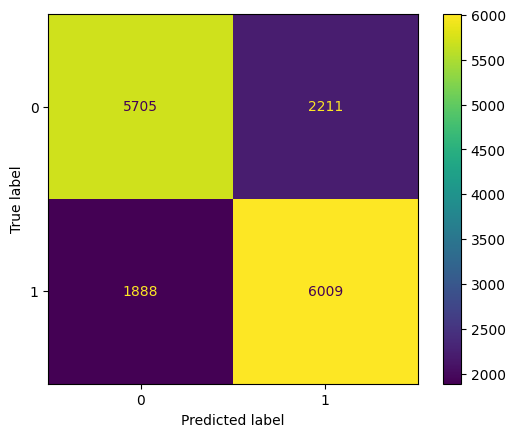

In [287]:
# the function expects the estimator, inputs and target as parameters
ConfusionMatrixDisplay.from_estimator(logreg_model_tfidf, X_test_scaled_tfidf, y_test)

Let's interpret these numbers of the confusion matrix:

* **True Negative**: `5722` are correctly predicted as negative Tweet
* **False Positive**: `2217` that where incorrectly classified as positive Tweet

* **False Negative**: `1866` incorrectly predicted as a negative Tweet 
* **True Positive**: `6008` correctly predicted as postive Tweet

The total of True values (TP + TN) are much higher than the total of False values (FP + FN) indicating a higher accuracy

But with regards to sentiment analysis we want a higher recall rate (how well the model identifies the positive or negative Tweet correctly vs the total positive or negative in the dataset)

In [288]:
#Now the classification report can be generated
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.75      0.72      0.74      7916
           1       0.73      0.76      0.75      7897

    accuracy                           0.74     15813
   macro avg       0.74      0.74      0.74     15813
weighted avg       0.74      0.74      0.74     15813



As we predicted we have a good accuracy score of 74%, and enough a decent recall rate 72% as negative Tweet and 76% for the positive Tweet. 

We can try to improve the recal rate by adjusting the threshold using y_proba.

Let's see how much the recall has improved after we adjust the y_proba rate to 0.2.

In [289]:
# Make probabilistic predictions (scores)
y_proba = logreg_model_tfidf.predict_proba(X_test_scaled)[:,1]

In [290]:
# First calculate precision and recall using the default (0.5) cut-off
y_threshold = np.where(y_proba > 0.5, 1, 0)
print("Threshold of 0.5:")
print(f"Precision score: {precision_score(y_test, y_threshold)}")
print(f"Recall score: {recall_score(y_test, y_threshold)}")
print("")

# Calculate the same using a much lower cut-off (0.2)
y_threshold = np.where(y_proba > 0.2, 1, 0)
print("Threshold of 0.2:")
print(f"Precision score: {precision_score(y_test, y_threshold)}")
print(f"Recall score: {recall_score(y_test, y_threshold)}")

Threshold of 0.5:
Precision score: 0.7450090744101633
Recall score: 0.7277447131822211

Threshold of 0.2:
Precision score: 0.6699521811261833
Recall score: 0.8693174623274661


So by reducing the y_proba from 0.5 to 0.2 we see an increase significantly in a Recall

### 4. Saving file

Before saving to file let's join the X_train and X_val to X_remainder

In [296]:
X_remainder = pd.concat([X_train_df_tfidf_vect, X_val_df_tfidf_vect])

In [297]:
X_remainder.shape[0] == X_rem.shape[0]

True

In [298]:
X_remainder.to_csv('rem_vectorized.csv', index=False)
X_test_df_tfidf_vect.to_csv('test_vectorized.csv', index=False)

In [299]:
y_rem.to_csv('y_rem.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [300]:
#sanity check
check_df = pd.read_csv('rem_vectorized.csv')
check_df

,able,absolutely,abt,accident,account,ache,act,action,actually,ad,...,youre,youre welcome,youtube,youve,youve got,yr,yum,yummy,yup,z
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.235473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---
## 5. Summary

To conclude this notebook, we went through a preprocessing feature engineer for text data. We used techniques of text vectorization including `CountVectorizer` and `TF-IDF`.

We also worked on the baseline model `Logistic Regression` and comparing the accuracy with a Text vectorizer method. In which we selected going with `TF-IDF Vectorizer`

In my next notebook, I will be using an advance machine learning models.